In [ ]:
cd 'drive/My Drive/colab_data/ml_project'

/content/drive/My Drive/colab_data/ml_project


In [ ]:
!pip install researchpy

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)


import re

import researchpy as rp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('data/jigsaw-toxic-comment-train.csv')

In [ ]:
for col in data.columns[2:]:
  data[col] = data[col].astype(np.bool)

### 1. Анализ всех дополнительных колонок тональности (как проявляется тот или иной тип токсичности, как в данных это представлено, какие есть пограничные случаи) - 2.5 балла

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  bool  
 3   severe_toxic   223549 non-null  bool  
 4   obscene        223549 non-null  bool  
 5   threat         223549 non-null  bool  
 6   insult         223549 non-null  bool  
 7   identity_hate  223549 non-null  bool  
dtypes: bool(6), object(2)
memory usage: 4.7+ MB


In [ ]:
data.describe()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,223549,223549,223549,223549,223549,223549,223549,223549
unique,223549,223549,2,2,2,2,2,2
top,09e5611793274042,"""\nStrong Oppose – same reasons as plus an A...",False,False,False,False,False,False
freq,1,1,202165,221587,211409,222860,212245,221432


Кажется, что столбцы `severe_toxic`, 	`obscene`,	`threat`, `insult`, `identity_hate` и так должны включать в себя обычную токсичность, но по всей видимости это не так.

In [ ]:
for col in data.columns[3:]:
  all_toxic = data.loc[data[col] == True, 'toxic'].all()
  print(f'{col} is always toxic: {all_toxic}')

severe_toxic is always toxic: True
obscene is always toxic: False
threat is always toxic: False
insult is always toxic: False
identity_hate is always toxic: False


Пропорции разных категорий в данных

In [ ]:
rp.summary_cat(data[data.columns[2:]])

,Variable,Outcome,Count,Percent
0,toxic,False,202165,90.43
1,,True,21384,9.57
2,severe_toxic,False,221587,99.12
3,,True,1962,0.88
4,obscene,False,211409,94.57
5,,True,12140,5.43
6,threat,False,222860,99.69
7,,True,689,0.31
8,insult,False,212245,94.94
9,,True,11304,5.06


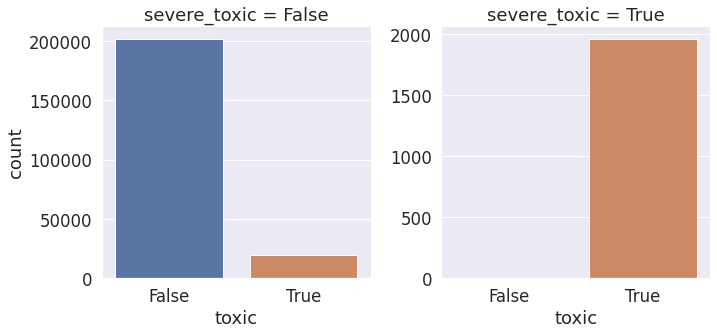

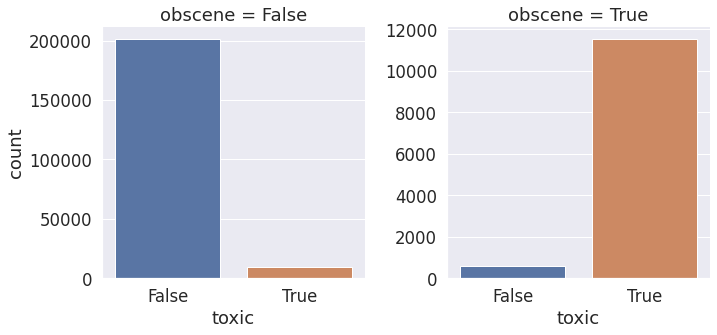

In [ ]:
for col in data.columns[3:5]:
  g = sns.catplot(x='toxic', kind='count', col=col, data=data, height=5, sharey=False)

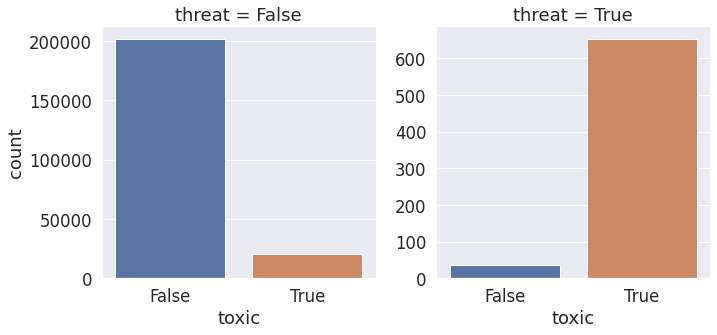

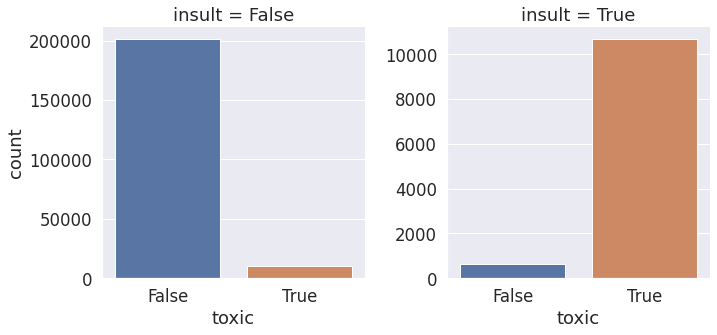

In [ ]:
for col in data.columns[5:7]:
  g = sns.catplot(x='toxic', kind='count', col=col, data=data, height=5, sharey=False)

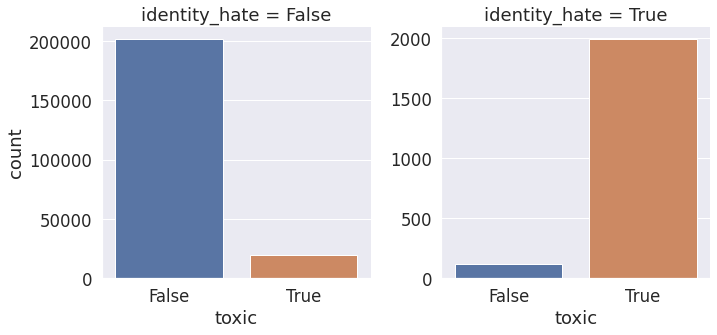

In [ ]:
for col in data.columns[7:]:
  g = sns.catplot(x='toxic', kind='count', col=col, data=data, height=5,  sharey=False)

Как видим, в данных встречаются не токсичные оскорбления (и остальные категории). Как это интерпретировать не очень ясно.

Например, утверждается, что комментарий ниже не токсичный. Как-то совсем не могу с этим согласиться. Что тогда токсичность вообще?

In [ ]:
import pprint
pprint.pprint(data.loc[(data.toxic == 0)&(data.insult == 1), 'comment_text'].iloc[0])

('REPLY ABOVE:\n'
 'That was me, loser. The UN defines Vietnam to be part of Southeast Asia. And '
 'far as I know Vietnam is part of ASEAN, and used to be part of French '
 'Indochina with Laos and all those shit countries Anyway your culture has '
 'always been more influenced by SEA than Han Chinese (as in proper Yangtze '
 'Han Chinese, not the fringe indigenous tribes in Guangzhou/Guangxi). \n'
 '\n'
 'Just admit that you vietnamese are all a bunch of wannabe crap people. ALL '
 "the east asian people I've spoken to thinks of Vietnam as a very integral "
 "part of SEA, and we all think you're backward, dirty and speak in a horrible "
 "swearing language. Doesn't matter what crap you spout on Wikipedia, won't "
 'change the way people in the real world think.')


Если посчитать коэффициент корреляции Пирсона для бинарных данных, то получается фи-коэффициент. Интерпретируется он аналогично.

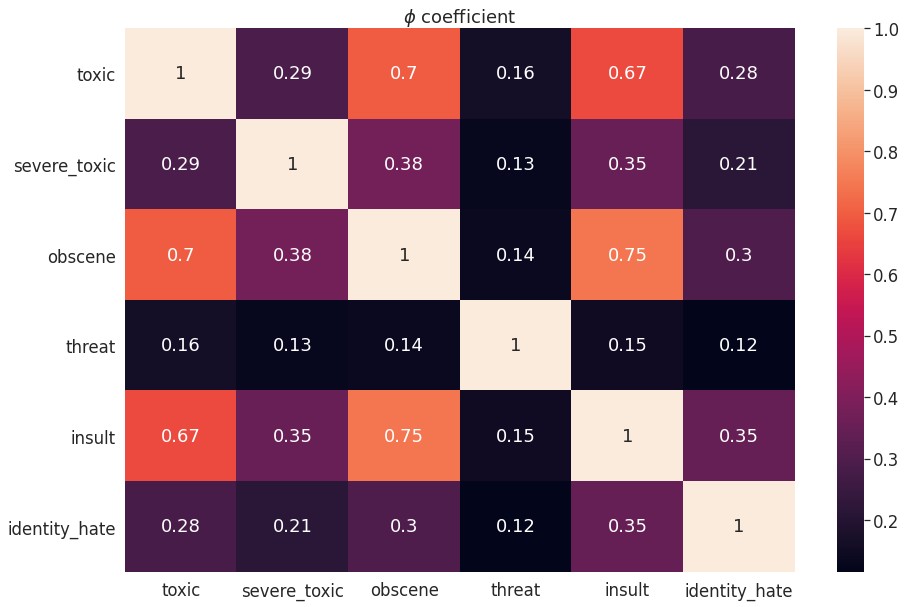

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(data=data.corr('pearson'), 
            annot=True, ax=ax)
plt.title("$\phi$ coefficient")
plt.show()

Можно заметить, что токсичность в данном датасете в наибольшей степени коррелирует с оскорблениями и обсценными комментариями, которые также сильно коррелируют между собой. Остальные категории связаны в меньшей степени.

In [ ]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
%%time
data['text_len'] = data.comment_text.str.len()
data['uppercase_num'] = data.comment_text.apply(lambda x: sum([1 for ch in x if ch.isupper()]))
data['non_alpha_chars'] = data.comment_text.apply(lambda x: sum([1 for ch in x if not ch.isalpha()]))
data['words'] = data.comment_text.apply(lambda x: word_tokenize(x))

CPU times: user 2min 40s, sys: 963 ms, total: 2min 41s
Wall time: 2min 41s


In [ ]:
data.words = data.words.apply(lambda x: [token for token in x if token.isalpha()])
data['words_num'] = data.words.str.len()

In [ ]:
data['caps_words_num'] = data.words.apply(lambda x: len([word for word in x if word.isupper()]))

In [ ]:
def unique_words(tokens):
  tokens = [token.lower() for token in tokens]
  if len(tokens):
    return len(set(tokens))/len(tokens)
  else:
    return 0

In [ ]:
data['unique_words_ratio'] = data.words.apply(unique_words)

In [ ]:
def get_stats(data, stat_col):
  result = []
  for col in data.columns[2:8]:
    df = data.groupby(col)[stat_col].agg(['mean', 'median', 'std', 'min', 'max'])
    df['kind'] = col
    df.index.names = ['outcome']
    result.append(df.reset_index().set_index(['kind', 'outcome']))
  return pd.concat(result)


Видим, что почти все категории комментариев, за исключением сильно токсичных, имеют меньшую длину в среднем. Большое стандартное отклонение `severe_toxic` говорит о том, что они имеют разнообразную длину, при этом медианное значение меньше, чем для `toxic`. <br>
Максимальное значение говорит о том, что все комментарии просто обрезали на 5000. 

In [ ]:
get_stats(data, 'text_len')

mean  median          std  min   max
kind          outcome                                            
toxic         False    402.691178     215   589.421496    1  5000
              True     280.604097     115   613.588485    3  5000
severe_toxic  False    389.999386     204   585.375077    1  5000
              True     505.456677     101  1155.576400    8  5000
obscene       False    397.332876     210   588.452135    1  5000
              True     280.951730     105   655.324758    5  5000
threat        False    391.241807     203   592.291709    1  5000
              True     316.910015     116   752.184495    7  5000
insult        False    397.340234     210   589.824691    1  5000
              True     272.206476     107   635.707254    7  5000
identity_hate False    391.744793     204   591.227063    1  5000
              True     314.438829     106   740.563345   11  5000

Количество заглавных букв сильно варьируетя в категориях, о чем говорит большее стандартное отклонение для значений `True`. В целом можно говорить о том, что в разного рода токсичных сообщениях встречается в среднем больше заглавных букв.

In [ ]:
get_stats(data, 'uppercase_num')

mean  median         std  min   max
kind          outcome                                           
toxic         False     14.484189       7   53.683837    0  4512
              True      44.689675       5  292.244483    0  4960
severe_toxic  False     15.988131       7   82.413565    0  4894
              True     173.841998       5  667.239832    0  4960
obscene       False     15.299590       7   70.508380    0  4717
              True      53.490033       4  334.567077    0  4960
threat        False     17.149430       7  101.564586    0  4960
              True      89.866473       4  424.575228    0  3917
insult        False     15.573931       7   75.440518    0  4894
              True      51.163393       4  326.509271    0  4960
identity_hate False     16.774599       7   95.159089    0  4894
              True      80.022201       5  441.804070    0  4960

Данные результаты можно интерпретировать как то, что в токсичных сообщениях используется меншье знаков пунктуации (и цифр, и прочих не алфавитных знаков), за исключением `severe_toxic`, где их, наоборот, больше. Видимо в таким сообщениях много повторяющихся знаков, например, восклицательных.

In [ ]:
get_stats(data, 'non_alpha_chars')

mean  median         std  min   max
kind          outcome                                           
toxic         False     92.321604      51  137.951428    0  4993
              True      67.262720      29  162.787830    0  4954
severe_toxic  False     89.637303      48  138.212619    0  4993
              True     122.365953      25  312.179820    1  4852
obscene       False     91.225511      50  138.823145    0  4993
              True      67.269275      27  168.652238    0  4954
threat        False     89.931585      48  140.081145    0  4993
              True      87.648766      27  277.517596    1  4619
insult        False     91.248345      50  139.393174    0  4993
              True      65.068825      27  161.481028    0  4852
identity_hate False     90.098491      48  140.368155    0  4993
              True      71.730751      26  171.836830    1  3176

Во всех категориях для `True` среднее и медианное значение ниже, чем для `False`. Исключением является `severe_toxic`, где, наоборот, среднее значение выше. У `severe_toxic` также самое высокое стандартное отклонение.

In [ ]:
get_stats(data, 'words_num')

mean  median         std  min   max
kind          outcome                                          
toxic         False    65.385418      35   95.353639    0  1803
              True     47.114852      20  103.974428    0  2142
severe_toxic  False    63.464847      33   94.986209    0  2142
              True     83.161060      18  196.568965    0  1403
obscene       False    64.592217      34   95.402650    0  1803
              True     47.015733      18  110.435634    0  2142
threat        False    63.661177      33   96.197854    0  2142
              True     56.047896      22  139.435622    2  1403
insult        False    64.577347      34   95.542781    0  1803
              True     45.995046      19  109.125503    0  2142
identity_hate False    63.756910      33   96.129181    0  2142
              True     51.170052      18  117.518447    0  1247

Сразу бросается в глаза большое количество слов, написанных большими буквами для всех категорий с `True`. Для `severe_toxic` это значение предсказуемо самое большое.

In [ ]:
get_stats(data, 'caps_words_num')

mean  median         std  min   max
kind          outcome                                          
toxic         False     2.535973       1   11.007011    0  1250
              True      9.399411       1   66.411450    0  2142
severe_toxic  False     2.887439       1   18.014308    0  2142
              True     37.646789       1  152.249102    0  1352
obscene       False     2.735428       1   15.526440    0  1352
              True     11.152224       1   74.809694    0  2142
threat        False     3.134650       1   22.350728    0  2142
              True     21.907112       1  108.778378    0  1069
insult        False     2.785521       1   16.041563    0  1352
              True     10.834130       1   75.483022    0  2142
identity_hate False     3.079433       1   21.663483    0  2142
              True     15.019839       1   85.574190    0  1247

Данный показатель оказался не очень информативным. Единственный вывод, который можно сделать — в оскорблениях и обсценных комментариях используется более разнообразная лексика.

In [ ]:
get_stats(data, 'unique_words_ratio')

mean    median       std       min  max
kind          outcome                                             
toxic         False    0.817587  0.833333  0.150263  0.000000  1.0
              True     0.851696  0.888889  0.178390  0.000000  1.0
severe_toxic  False    0.821207  0.840000  0.151872  0.000000  1.0
              True     0.780555  0.866667  0.279794  0.000000  1.0
obscene       False    0.819072  0.837838  0.151121  0.000000  1.0
              True     0.851814  0.894737  0.187604  0.000000  1.0
threat        False    0.820881  0.840000  0.153303  0.000000  1.0
              True     0.810987  0.851852  0.208565  0.006536  1.0
insult        False    0.819217  0.837838  0.151612  0.000000  1.0
              True     0.851512  0.888889  0.182806  0.000000  1.0
identity_hate False    0.820698  0.840000  0.152880  0.000000  1.0
              True     0.836789  0.888889  0.208197  0.000000  1.0

### 2. Бейзлайн модель из sklearn (векторайзер + модель) с отбором признаков (через l1 регуляризацию, на глаз через анализ важных параметров или через permutation importance)<br> *2 балла*

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=0)

In [ ]:
data = data[data.columns[:8]]

In [ ]:
vectorizer = TfidfVectorizer(min_df=3, max_df=0.7, max_features=50000)

In [ ]:
vectorizer.fit(train.comment_text.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.7, max_features=50000,
                min_df=3, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
X_train = vectorizer.transform(train.comment_text)
X_test = vectorizer.transform(test.comment_text)

In [ ]:
y_train = train.toxic
y_test = test.toxic

#### 2.1 Эксперимент с L1 регуляризацией

In [ ]:
regressions = []
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

for c in c_values:
  regressions.append(LogisticRegression(max_iter=1000,
                                        C=c,
                                        penalty='l1',
                                        solver='liblinear'))

for c, reg in zip(c_values, regressions):
  reg.fit(X_train, y_train)
  y_pred = reg.predict(X_test)
  y_pred_proba = reg.predict_proba(X_test)[:, 1]
  roc = roc_auc_score(y_test, y_pred_proba)
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f'Metrics for C={c}:' + '\n' + f'ROC AUC:{roc}' + '\n' 
        + f'Accuracy:{acc}' + '\n' + f'F1: {f1}' + '\n'
        )

Metrics for C=0.0001:
ROC AUC:0.5
Accuracy:0.9031536569000224
F1: 0.0

Metrics for C=0.001:
ROC AUC:0.5
Accuracy:0.9031536569000224
F1: 0.0

Metrics for C=0.01:
ROC AUC:0.8388908258381403
Accuracy:0.9211660329531052
F1: 0.3215706403182343

Metrics for C=0.1:
ROC AUC:0.9445778079758842
Accuracy:0.9455155446208902
F1: 0.6386471518987341

Metrics for C=1:
ROC AUC:0.9704300523014426
Accuracy:0.9541340490568851
F1: 0.7285083848190644

Metrics for C=10:
ROC AUC:0.9550296560402632
Accuracy:0.9493625587116976
F1: 0.7169056352117372

Metrics for C=100:
ROC AUC:0.9168674484875082
Accuracy:0.9306344591068366
F1: 0.6403834260977118

Metrics for C=1000:
ROC AUC:0.8763174197192364
Accuracy:0.9106091105643779
F1: 0.5691699604743082



Возьмем коэффициенты классификатора с наилучшими результатами (C=1, C=10).

In [ ]:
l1_coefs = regressions[4].coef_[0]

Оставим только те фичи, которые не обнулились.

In [ ]:
l1_coefs = l1_coefs[np.nonzero(l1_coefs)[0]]

In [ ]:
len(l1_coefs)

1640

In [ ]:
l1_coefs = l1_coefs.argsort()[::-1]

In [ ]:
vec_vocab = {v:k for k,v in vectorizer.vocabulary_.items()}

Тут сразу видно, что с коэффициентами что-то не то.

In [ ]:
for c in l1_coefs[:3]:
  print(vec_vocab[c])

1963
5pm
229


Для C=10 получаем хотя бы слова, но доверия они не вызывают.

In [ ]:
l1_coefs = regressions[5].coef_[0]
l1_coefs = l1_coefs[np.nonzero(l1_coefs)[0]]
l1_coefs = l1_coefs.argsort()[::-1]
for c in l1_coefs[:3]:
  print(vec_vocab[c])

alphachimp
armadillo
cosmological


Попробуем обучить модель на этих признаках.

In [ ]:
l1_feats_log = LogisticRegression(max_iter=1000, C=10)
l1_feats_log.fit(X_train[:, l1_coefs], y_train)
l1_preds = l1_feats_log.predict(X_test[:, l1_coefs])
l1_preds_proba = l1_feats_log.predict_proba(X_test[:, l1_coefs])[:, 1]
print(f'ROC AUC: {roc_auc_score(y_test, l1_preds_proba)}')
print(f'Accuracy: {accuracy_score(y_test, l1_preds)}')
print(f'F1: {f1_score(y_test, l1_preds)}')

ROC AUC: 0.8388602896552548
Accuracy: 0.9175277715648997
F1: 0.3389506394167563


Кажется, что это не очень хороший результат. Попробуем воспользоваться N самых значимых признаков логистической регрессии с L2 регуляризацией.

#### 2.2 Основная часть

In [ ]:
log = LogisticRegression(max_iter=1000, C=10)

In [ ]:
%%time
log.fit(X_train, y_train)

CPU times: user 26.1 s, sys: 18.8 s, total: 44.9 s
Wall time: 23 s


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds = log.predict(X_test)

In [ ]:
probs = log.predict_proba(X_test)[:, 1]

Уже видим, что без отбора признаков результат уже лучше.

In [ ]:
accuracy_score(y_test, preds)

0.9535972563930515

In [ ]:
roc_auc_score(y_test, probs)

0.9667643999912049

In [ ]:
f1_score(y_test, preds)

0.729391304347826

Попробуем отобрать значимые признаки, основываясь на значениях коэффициентов зафиченной регрессии.

In [ ]:
coefs = log.coef_[0]

In [ ]:
all_ind = coefs.argsort()[-50000:][::-1]

Выясним какое количество фичей является оптимальным для отбора.

In [ ]:
%%time
num_features = [25, 50, 100, 200, 500, 1000, 2000, 5000, 8000,
                10000, 20000, 30000, 40000, 50000]
acc = []
roc = []
f1 = []
for num in num_features:
  clf = LogisticRegression(max_iter=1000, C=10)
  clf.fit(X_train[:, all_ind[:num]], y_train)
  tmp_preds = clf.predict(X_test[:, all_ind[:num]])
  tmp_probs = clf.predict_proba(X_test[:, all_ind[:num]])[:, 1]
  acc.append(accuracy_score(y_test, tmp_preds))
  roc.append(roc_auc_score(y_test, tmp_probs))
  f1.append(f1_score(y_test, tmp_preds))

CPU times: user 2min 11s, sys: 1min 7s, total: 3min 19s
Wall time: 2min


In [ ]:
feats = pd.DataFrame(data={'num_features': num_features, 'acc': acc, 'roc': roc, 'f1': f1})

In [ ]:
feats

,num_features,acc,roc,f1
0,25,0.940550,0.780548,0.594364
1,50,0.943726,0.812657,0.629564
2,100,0.946321,0.863546,0.661463
3,200,0.948065,0.910824,0.679370
4,500,0.949422,0.931430,0.693254
5,1000,0.950153,0.943736,0.700421
6,2000,0.950406,0.952366,0.703565
7,5000,0.951077,0.960256,0.709415
8,8000,0.951390,0.962802,0.710942
9,10000,0.951465,0.964050,0.711666


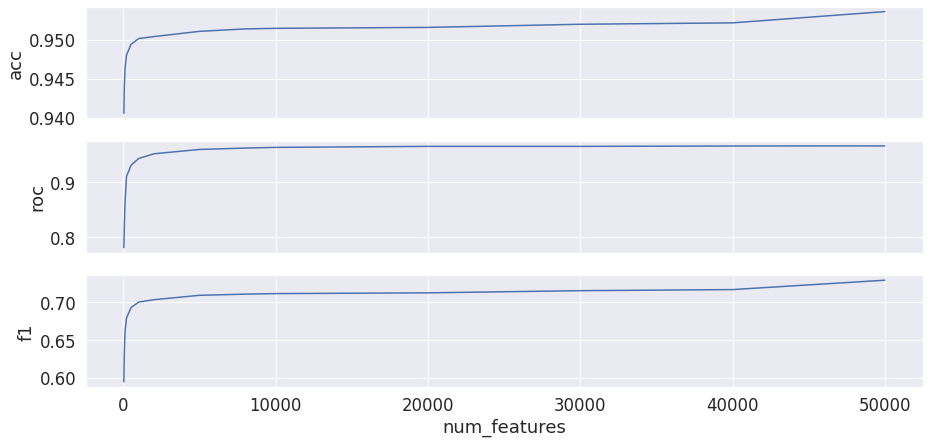

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
sns.lineplot(x='num_features', y='acc', data=feats, ax=axs[0])
sns.lineplot(x='num_features', y='roc', data=feats, ax=axs[1])
sns.lineplot(x='num_features', y='f1', data=feats, ax=axs[2])
plt.show()

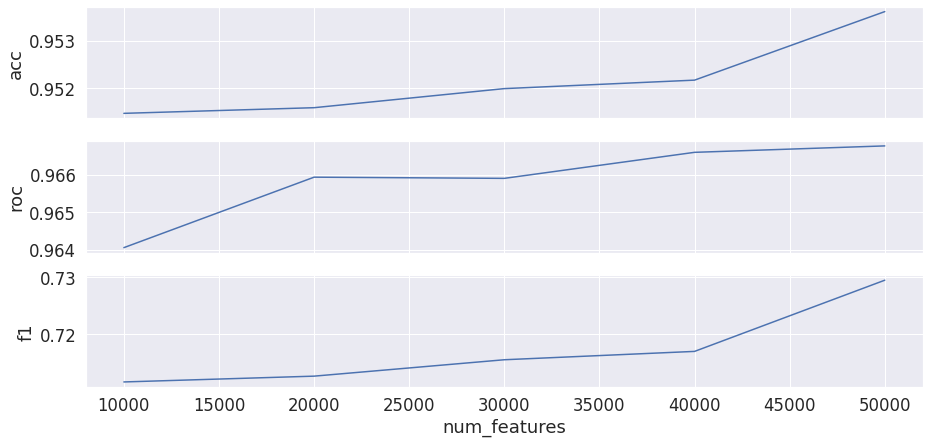

In [ ]:
big_feats = feats.loc[feats.num_features >= 10000]
fig, axs = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
sns.lineplot(x='num_features', y='acc', data=big_feats, ax=axs[0])
sns.lineplot(x='num_features', y='roc', data=big_feats, ax=axs[1])
sns.lineplot(x='num_features', y='f1', data=big_feats, ax=axs[2])
plt.show()

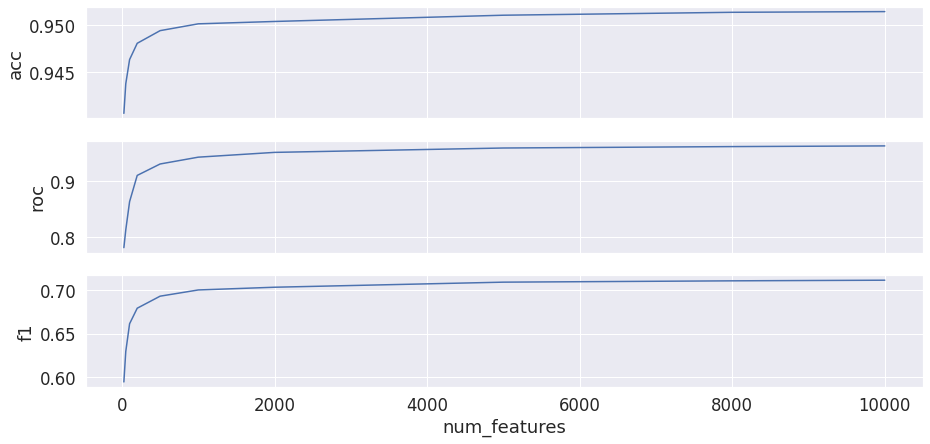

In [ ]:
low_feats = feats.loc[feats.num_features <= 10000]
fig, axs = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
sns.lineplot(x='num_features', y='acc', data=low_feats, ax=axs[0])
sns.lineplot(x='num_features', y='roc', data=low_feats, ax=axs[1])
sns.lineplot(x='num_features', y='f1', data=low_feats, ax=axs[2])
plt.show()

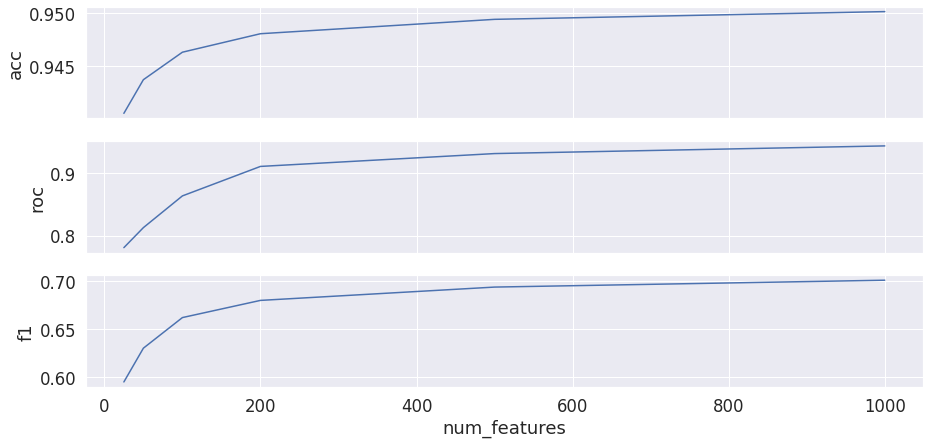

In [ ]:
low_feats = feats.loc[feats.num_features <= 1000]
fig, axs = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
sns.lineplot(x='num_features', y='acc', data=low_feats, ax=axs[0])
sns.lineplot(x='num_features', y='roc', data=low_feats, ax=axs[1])
sns.lineplot(x='num_features', y='f1', data=low_feats, ax=axs[2])
plt.show()

По графикам видим, что увеличение количества признаков приводит к непропорционально маленькому росту качества. Целесообразно выбирать на интервале от 200 до 1000, т.к. дальше наклон сильно уменьшается. После 1000 уже почти прямая.

In [ ]:
ind = all_ind[:1000]

In [ ]:
log_2 = LogisticRegression(max_iter=1000, C=10)

In [ ]:
log_2.fit(X_train[:, ind], y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds_2 = log_2.predict(X_test[:, ind])

In [ ]:
preds_2_proba = log_2.predict_proba(X_test[:, ind])[:, 1]

Результат с частью фичей предсказуемо хуже, хотя сильно лучше, чем на фичах, отобранных L1.

In [ ]:
accuracy_score(y_test, preds_2)

0.9501528368001193

In [ ]:
f1_score(y_test, preds_2)

0.7004211846939691

In [ ]:
roc_auc_score(y_test, preds_2_proba)

0.9437355261022341

### 3. Стакинг бустингов (как минимум 2 уровня xboost/catboost/lightgbm, можно использовать публичные кернелы любых соревнований)<br> *3 балла*

Бустинги плохо работают при очень большом количестве данных. Поэтому есть смысл использовать значимые признаки из предущего пункта.

In [ ]:
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
base_learners = [
                 ('lgbm_1', LGBMClassifier(objective='binary')), 
                 ('lgbm_2', LGBMClassifier(objective='binary')),
                 ('lgbm_3', LGBMClassifier(objective='binary')),
                 ('lgbm_4', LGBMClassifier(objective='binary')),
                 ('lgbm_5', LGBMClassifier(objective='binary')),
                 ('xgb_1', XGBClassifier(learning_rate=0.01)),
                 ('xgb_2', XGBClassifier(learning_rate=0.01)),
                 ('xgb_3', XGBClassifier(learning_rate=0.01)),
                 ('xgb_4', XGBClassifier(learning_rate=0.01)),
                 ('xgb_5', XGBClassifier(learning_rate=0.01))    
                ]

In [ ]:
clf = StackingClassifier(estimators=base_learners, final_estimator=LGBMClassifier(objective='binary',
                                                                                  min_child_samples=30))

In [ ]:
%%time
_ = clf.fit(X_train[:, ind], y_train)

CPU times: user 4min 16s, sys: 1.28 s, total: 4min 18s
Wall time: 3min 58s


In [ ]:
stack_preds = clf.predict(X_test[:, ind])

In [ ]:
stack_preds_proba = clf.predict_proba(X_test[:, ind])[:, 1]

Получаем небольшой прирост по сравнению с предыдущей моделью (в f1 и roc auc, но не accuracy).

In [ ]:
f1_score(y_test, stack_preds)

0.7071212775140269

In [ ]:
accuracy_score(y_test, stack_preds)

0.9494072914336837

In [ ]:
roc_auc_score(y_test, stack_preds_proba)

0.9360528545662499

### 4. Использование токенизации на символьные нграммы (не параметром analyzer=’char’, а вручную или готовым инструментом вроде youtokentome)<br> *2 балла*

In [ ]:
!pip install youtokentome

     |████████████████████████████████| 1.7MB 2.8MB/s 


In [ ]:
import youtokentome as yttm

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=0) # токенизатор нужно обучать только на тестовых данных

In [ ]:
comments = train.comment_text.to_csv(index=False, header=None) # можно записывать csv не в файл, а просто в переменную

In [ ]:
with open('data/comments.txt', 'w') as file: # youtokentome нужно обучать на данных именно из файла
  new_comments = re.sub(r'\"{2,}', '', comments) # можно заодно почистить разделители между текстами
  new_comments = re.sub(r'\n+', ' ', new_comments)
  file.write(new_comments)

In [ ]:
%%time
# чтобы использовать модель нужно опять же её сохранить в файл, а потом прочитать из него
yttm.BPE.train('data/comments.txt', 'data/bpe.model', vocab_size=4000, coverage=0.9999, n_threads=-1, pad_id=0, unk_id=1) 

CPU times: user 7.84 s, sys: 497 ms, total: 8.34 s
Wall time: 5.85 s


In [ ]:
bpe_model = yttm.BPE('data/bpe.model', n_threads=-1) # читаем модель из файла

In [ ]:
%%time
encoded_comments = bpe_model.encode(data.comment_text.tolist(), output_type=yttm.OutputType.ID) # на выходе получаем сразу ID подслов в предложениях, что нам и нужно на входе в сеть

CPU times: user 16.8 s, sys: 404 ms, total: 17.2 s
Wall time: 10.7 s


In [ ]:
data['encoded_comments'] = encoded_comments # записываем закодированные версии для всех предложений

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=0) # опять делим на трейн и тест (с тем же сидом, чтобы разделение было такое же)

In [ ]:
[bpe_model.id_to_subword(num) for num in encoded_comments[0]][:10] # модель содержит словарь подслов

['▁Ex',
 'pl',
 'an',
 'ation',
 '▁Why',
 '▁the',
 '▁edits',
 '▁made',
 '▁under',
 '▁my']

### 5. Любая нейронная модель (минимум 5 слоев) с Dropout, Pooling и колбеками - 2 балла

In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, AlphaDropout, InputLayer, Embedding, Conv1D, Flatten, Input, AveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

In [ ]:
  def f1(y_true, y_pred):
  
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
max_seq_len = min(max(len(text) for text in train.encoded_comments.values), 300)

In [ ]:
X_train = train.encoded_comments
X_test = test.encoded_comments

In [ ]:
y_train = train.toxic.astype('float')
y_test = test.toxic.astype('float')

In [ ]:
X_train_pad, X_test_pad = pad_sequences(X_train, maxlen=max_seq_len, padding='post'), pad_sequences(X_test, maxlen=max_seq_len, padding='post')

In [ ]:
inputs = Input(shape=(max_seq_len,), name='comment_input')

emb = Embedding(len(bpe_model.vocab()), input_length=max_seq_len, output_dim=100, mask_zero=True)(inputs)

conv_1 = Conv1D(64, 3, 1, padding='same', name='conv_1')(emb)
conv_2 = Conv1D(64, 3, 1, padding='same', name='conv_2')(conv_1)
pool_1 = AveragePooling1D()(conv_2)
drop_1 = AlphaDropout(0.1)(pool_1)

conv_3 = Conv1D(64, 3, 1, padding='same', name='conv_3')(drop_1)
conv_4 = Conv1D(64, 3, 1, padding='same', name='conv_4')(conv_3)
pool_2 = AveragePooling1D()(conv_4)
drop_2 = AlphaDropout(0.1)(pool_2)

flat = Flatten()(drop_2)

dense_1 = Dense(200, activation='relu', kernel_regularizer='l2')(flat)
drop_3 = AlphaDropout(0.1)(dense_1)
dense_2 = Dense(100, activation='relu', kernel_regularizer='l2')(drop_3)

outputs = Dense(1, activation='sigmoid')(dense_2)

model = Model(inputs=inputs, outputs=outputs)

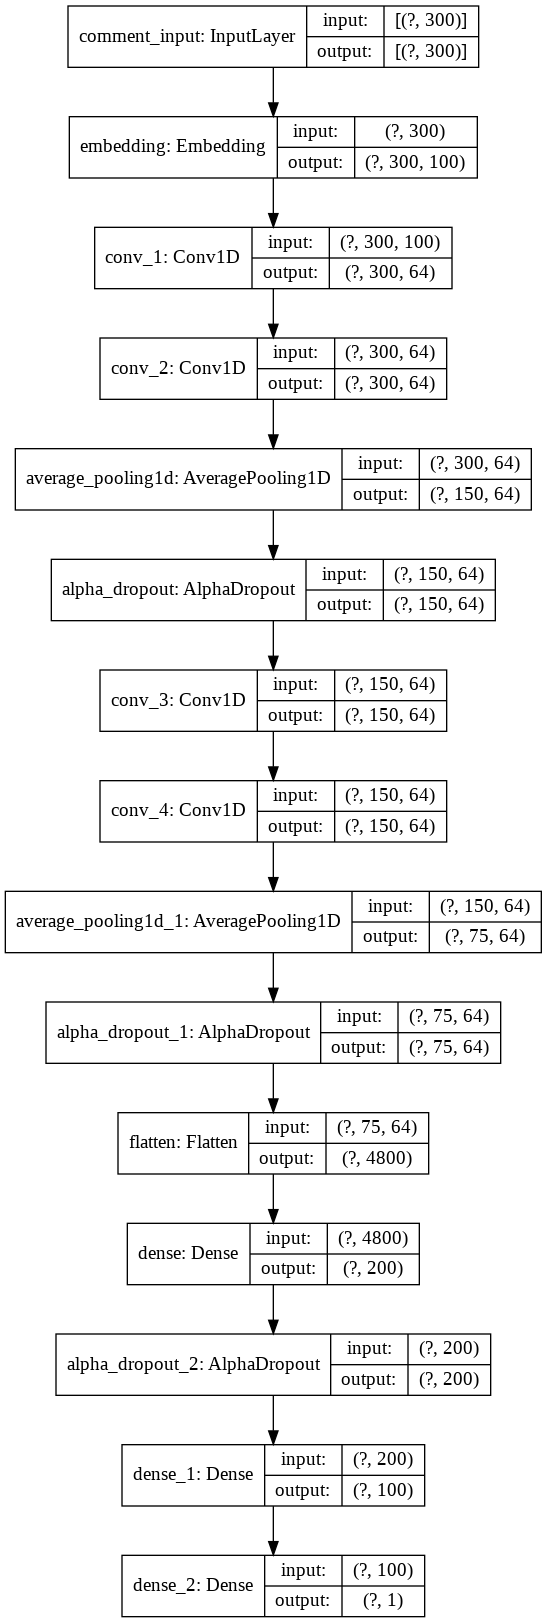

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('data/model.weights', 
                                                monitor='val_f1',
                                                verbose=1,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='max',
                                                save_freq='epoch')

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
auc = tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC', summation_method='interpolation', name='roc_auc',
    dtype=None, thresholds=None, multi_label=False, label_weights=None
    )

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1, 'accuracy', auc])

In [ ]:
model.fit(X_train_pad, y_train, 
          validation_data=(X_test_pad, y_test),
          batch_size=4000,
          epochs=40,
          callbacks=[checkpoint, early_stop])

Epoch 1/40
40/40 [==============================] - ETA: 0s - loss: 2.4681 - f1: 0.0115 - accuracy: 0.8892 - roc_auc: 0.5397
Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to data/model.weights
40/40 [==============================] - 37s 913ms/step - loss: 2.4681 - f1: 0.0115 - accuracy: 0.8892 - roc_auc: 0.5397 - val_loss: 1.0616 - val_f1: 0.0000e+00 - val_accuracy: 0.9032 - val_roc_auc: 0.7817
Epoch 2/40
40/40 [==============================] - ETA: 0s - loss: 0.7527 - f1: 0.3253 - accuracy: 0.9167 - roc_auc: 0.8781
Epoch 00002: val_f1 improved from 0.00000 to 0.62640, saving model to data/model.weights
40/40 [==============================] - 34s 862ms/step - loss: 0.7527 - f1: 0.3253 - accuracy: 0.9167 - roc_auc: 0.8781 - val_loss: 0.5193 - val_f1: 0.6264 - val_accuracy: 0.9282 - val_roc_auc: 0.9268
Epoch 3/40
40/40 [==============================] - ETA: 0s - loss: 0.3875 - f1: 0.6330 - accuracy: 0.9388 - roc_auc: 0.9367
Epoch 00003: val_f1 improved from 0.62640 

In [ ]:
model.load_weights('data/model.weights')

In [ ]:
def toxic_predictor(text):
  encoded_text = bpe_model.encode(text, output_type=yttm.OutputType.ID)
  encoded_text = pad_sequences([encoded_text], maxlen=max_seq_len, padding='post')
  pred = model.predict(encoded_text)[0][0] > 0.5
  return pred 


In [ ]:
toxic_predictor('WHAT A STUPID STUPID STUPID CLASSIFIER!!!!!! THIS CLASSIFIER SUCKS!!!!')

True